In [9]:
#libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
#loading datasets
base_path = "D:/DATA PROJECT/data"
gc_npz = os.path.join(base_path, "GoldCoast", "GoldCoast", 
                           "current_wind_20100101_20241231_GoaldCoast.npz")
sy_npz = os.path.join(base_path, "Sydney_NewCastle", "Sydney_NewCastle", 
                           "current_wind_20100101_20241231_Sydney.npz")


channel_names = ["U current", "V current", "Sea surface temp", 
                 "Salinity", "U wind", "V wind"]


gc_data = np.load(gc_npz)
sy_data = np.load(sy_npz)


gc_main = gc_data["UVTempSalt_UVTs"]  
sy_main = sy_data["UVTempSalt_UVTs"]

dates = pd.date_range("2010-01-01", "2024-12-31", freq="D")

sy = pd.read_csv(r"D:\DATA PROJECT\Sydney_stings.csv",
                 parse_dates=['time'], dayfirst=True)
gc = pd.read_csv(r"D:\DATA PROJECT\goaldcoast_stings.csv", 
                 parse_dates=['time'], dayfirst=True)

for df in (sy, gc):
    df['time'] = df['time'].dt.tz_localize(None)
    df['date'] = df['time'].dt.normalize()

sy['Region'] = 'Sydney'
gc['Region'] = 'Gold Coast'

stings = (pd.concat([sy, gc], ignore_index=True)
            .rename(columns={'Stings_sum':'stings_sum',
                             'Stings_binary':'stings_binary'})
            [['Region','date','stings_sum','stings_binary']])

In [4]:
# Checking grid size and valid ocean cells
# Mask is True where valid ocean data exist (not NaN for all time)

gc_mask = ~np.isnan(gc_main[:, 0, :, :]).all(axis=0)
sy_mask = ~np.isnan(sy_main[:, 0, :, :]).all(axis=0)

print("Gold Coast grid:", gc_mask.shape, "valid ocean cells:", gc_mask.sum())
print("Sydney grid:", sy_mask.shape, "valid ocean cells:", sy_mask.sum())


Gold Coast grid: (15, 15) valid ocean cells: 183
Sydney grid: (13, 13) valid ocean cells: 118


In [6]:
#converting masked 4D array (time, channel, H, W) into a dataframe with daily averages for each channel

def make_df(region_name, data, mask, dates, channels):
    T, C, H, W = data.shape
    rows = {}
    for i, chn in enumerate(channels):
        masked_vals = data[:, i, :, :][:, mask] #only take ocean cells
        daily_avg = np.nanmean(masked_vals, axis=1)
        rows[chn] = daily_avg
    df = pd.DataFrame(rows, index=dates)
    df.index.name = "Date"
    df["Region"] = region_name
    return df

gc_df = make_df("Gold Coast", gc_main, gc_mask, dates, channel_names)
sy_df = make_df("Sydney", sy_main, sy_mask, dates, channel_names)

all_df = pd.concat([gc_df, sy_df])
all_df.head(10)


U current  V current  Sea surface temp   Salinity    U wind  \
Date                                                                      
2010-01-01  -0.101543  -0.682206         25.984117  35.310858 -1.350650   
2010-01-02  -0.035152  -0.685357         25.928812  35.348238  1.565029   
2010-01-03  -0.230347  -0.546167         26.009888  35.358243 -3.923860   
2010-01-04  -0.192440  -0.600306         25.745936  35.374060 -6.002225   
2010-01-05  -0.178490  -0.552857         25.732278  35.371389 -5.123858   
2010-01-06  -0.133753  -0.498218         25.921495  35.365305 -2.511772   
2010-01-07  -0.213470  -0.417091         26.086436  35.383106 -4.707287   
2010-01-08  -0.211123  -0.367580         26.116103  35.388099 -5.255721   
2010-01-09  -0.171594  -0.365517         26.233437  35.406379 -3.370998   
2010-01-10  -0.139649  -0.379221         26.666425  35.370313 -1.978729   

              V wind      Region  
Date                              
2010-01-01 -6.638138  Gold Coast  
2010-01-02 -8.252087  Gold Coast  
2010-01-03  6.502674  Gold Coast  
2010-01-04  6.037926  Gold Coast  
2010-01-05  2.970986  Gold Coast  
2010-01-06 -1.456332  Gold Coast  
2010-01-07  0.398544  Gold Coast  
2010-01-08  1.778475  Gold Coast  
2010-01-09 -0.287061  Gold Coast  
2010-01-10 -1.203467  Gold Coast

In [7]:
#statistical summary

summary = all_df.groupby("Region").agg(
    ["mean", "std", "min", "max"])
summary

U current                               V current            \
                mean       std       min       max      mean       std   
Region                                                                   
Gold Coast -0.008911  0.099859 -0.366549  0.411589 -0.366857  0.188741   
Sydney     -0.152917  0.168359 -0.713490  0.319542 -0.248096  0.237114   

                               Sea surface temp            ...   Salinity  \
                 min       max             mean       std  ...        min   
Region                                                     ...              
Gold Coast -1.084770  0.231902        24.025299  1.912614  ...  34.959118   
Sydney     -1.070762  0.417203        21.680250  2.138813  ...  35.133101   

                         U wind                                    V wind  \
                  max      mean       std        min        max      mean   
Region                                                                      
Gold Coast  35.836392 -1.358530  3.889554 -17.033267  12.591706  0.626570   
Sydney      35.819766 -0.161382  4.461667 -16.176857  16.230287  0.034393   

                                            
                 std        min        max  
Region                                      
Gold Coast  5.435193 -13.545776  17.736387  
Sydney      5.493073 -12.615044  17.403279  

[2 rows x 24 columns]

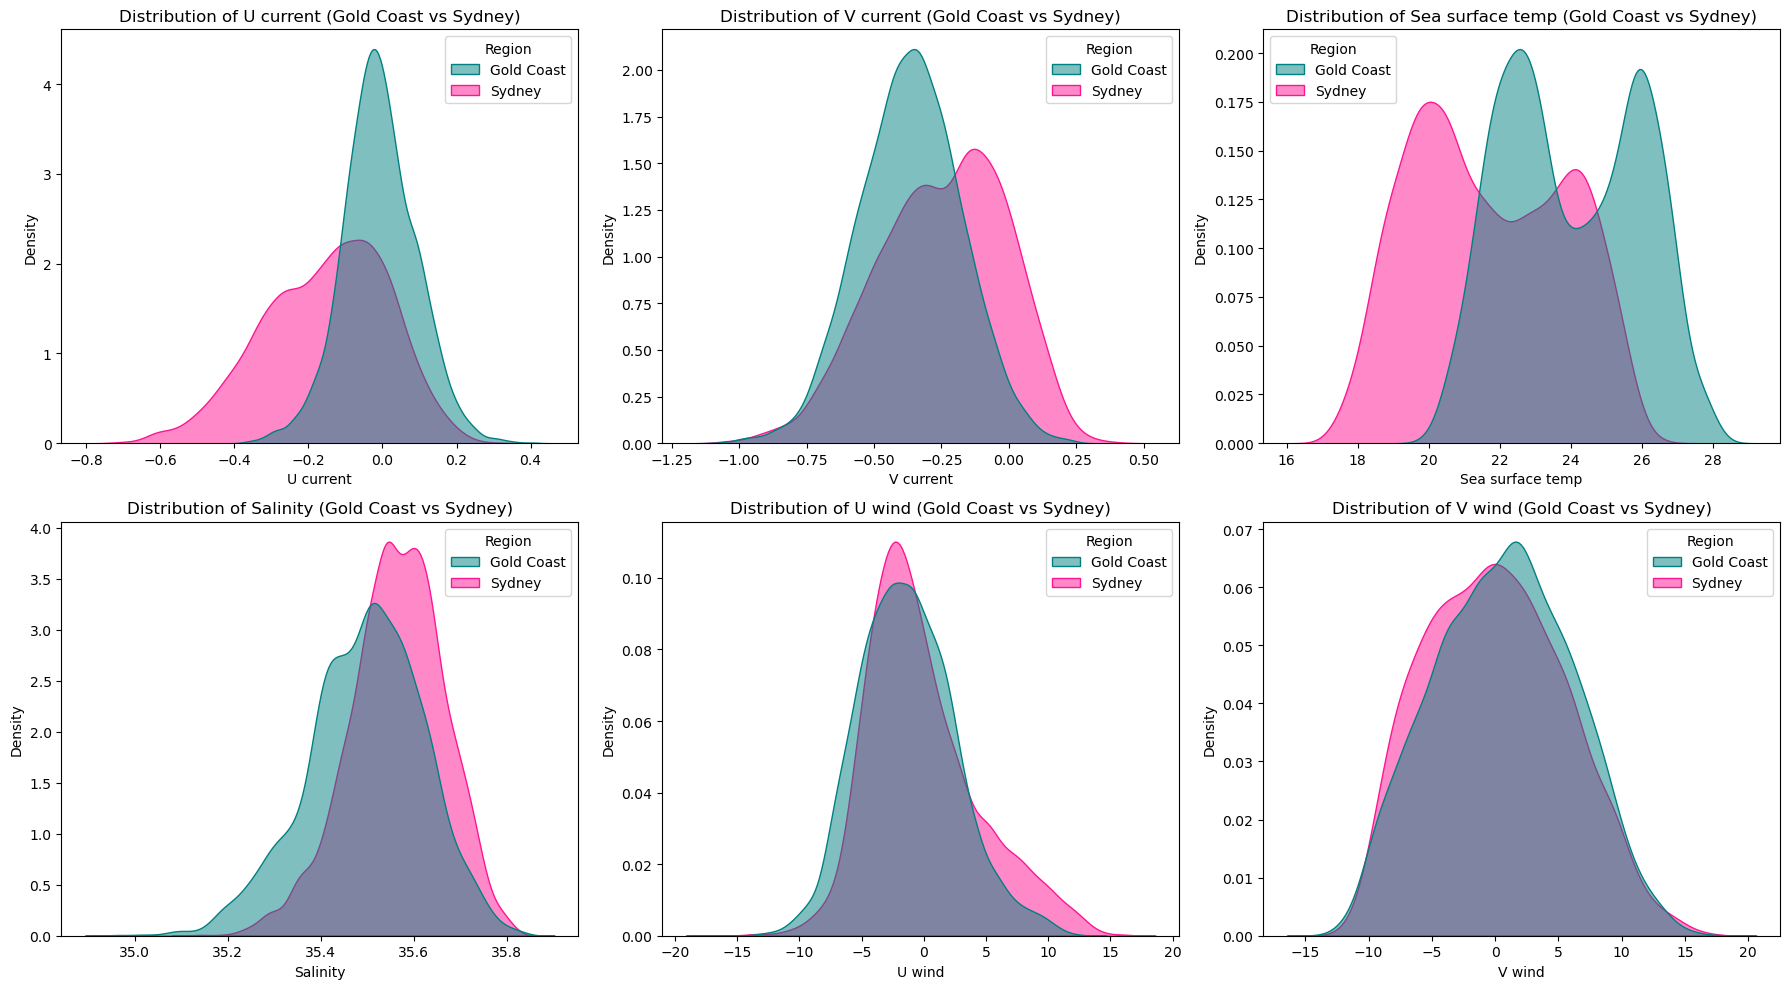

In [12]:
#environmental variables distributions 

palette = {"Gold Coast": "#008080", "Sydney": "#FF1493"}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))  #2x3 grid
axes = axes.flatten()  

for i, evar in enumerate(channel_names):
    sns.kdeplot(
        data=all_df, x=evar, hue="Region",
        fill=True, common_norm=False, alpha=0.5,
        palette=palette, ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {evar} (Gold Coast vs Sydney)")
    axes[i].set_xlabel(evar)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

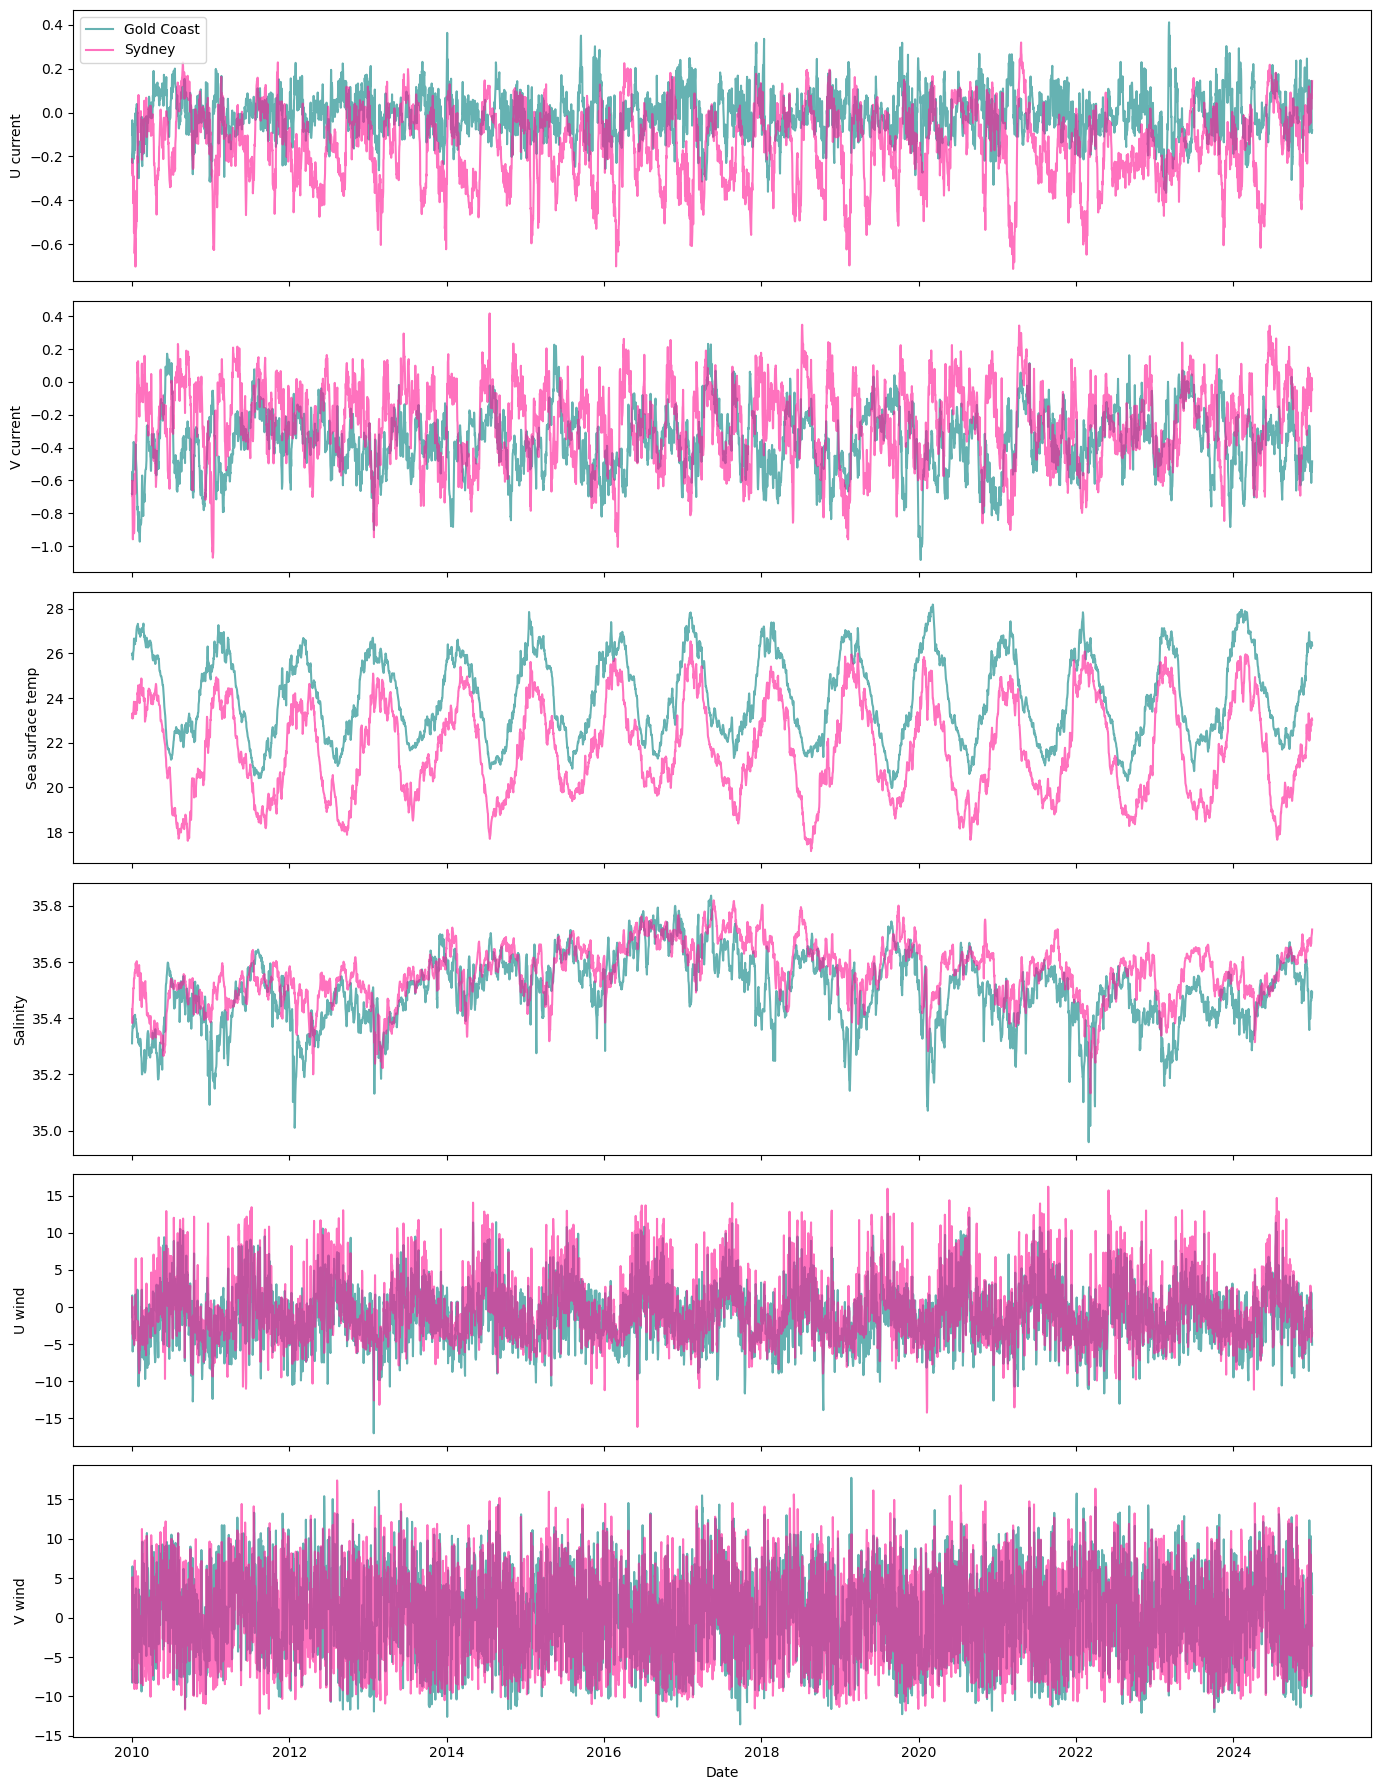

In [16]:
#time series analysis 

fig, axes = plt.subplots(6, 1, figsize=(14, 18), sharex=True)

for i, evar in enumerate(channel_names):
    ax = axes[i]
    ax.plot(gc_df.index, gc_df[evar], 
            label="Gold Coast", color=palette["Gold Coast"], alpha=0.6)
    ax.plot(sy_df.index, sy_df[evar], 
            label="Sydney", color=palette["Sydney"], alpha=0.6)
    
    ax.set_ylabel(evar)
    if i == 0:
        ax.legend()
    if i == 5:
        ax.set_xlabel("Date")

plt.tight_layout()
plt.show()


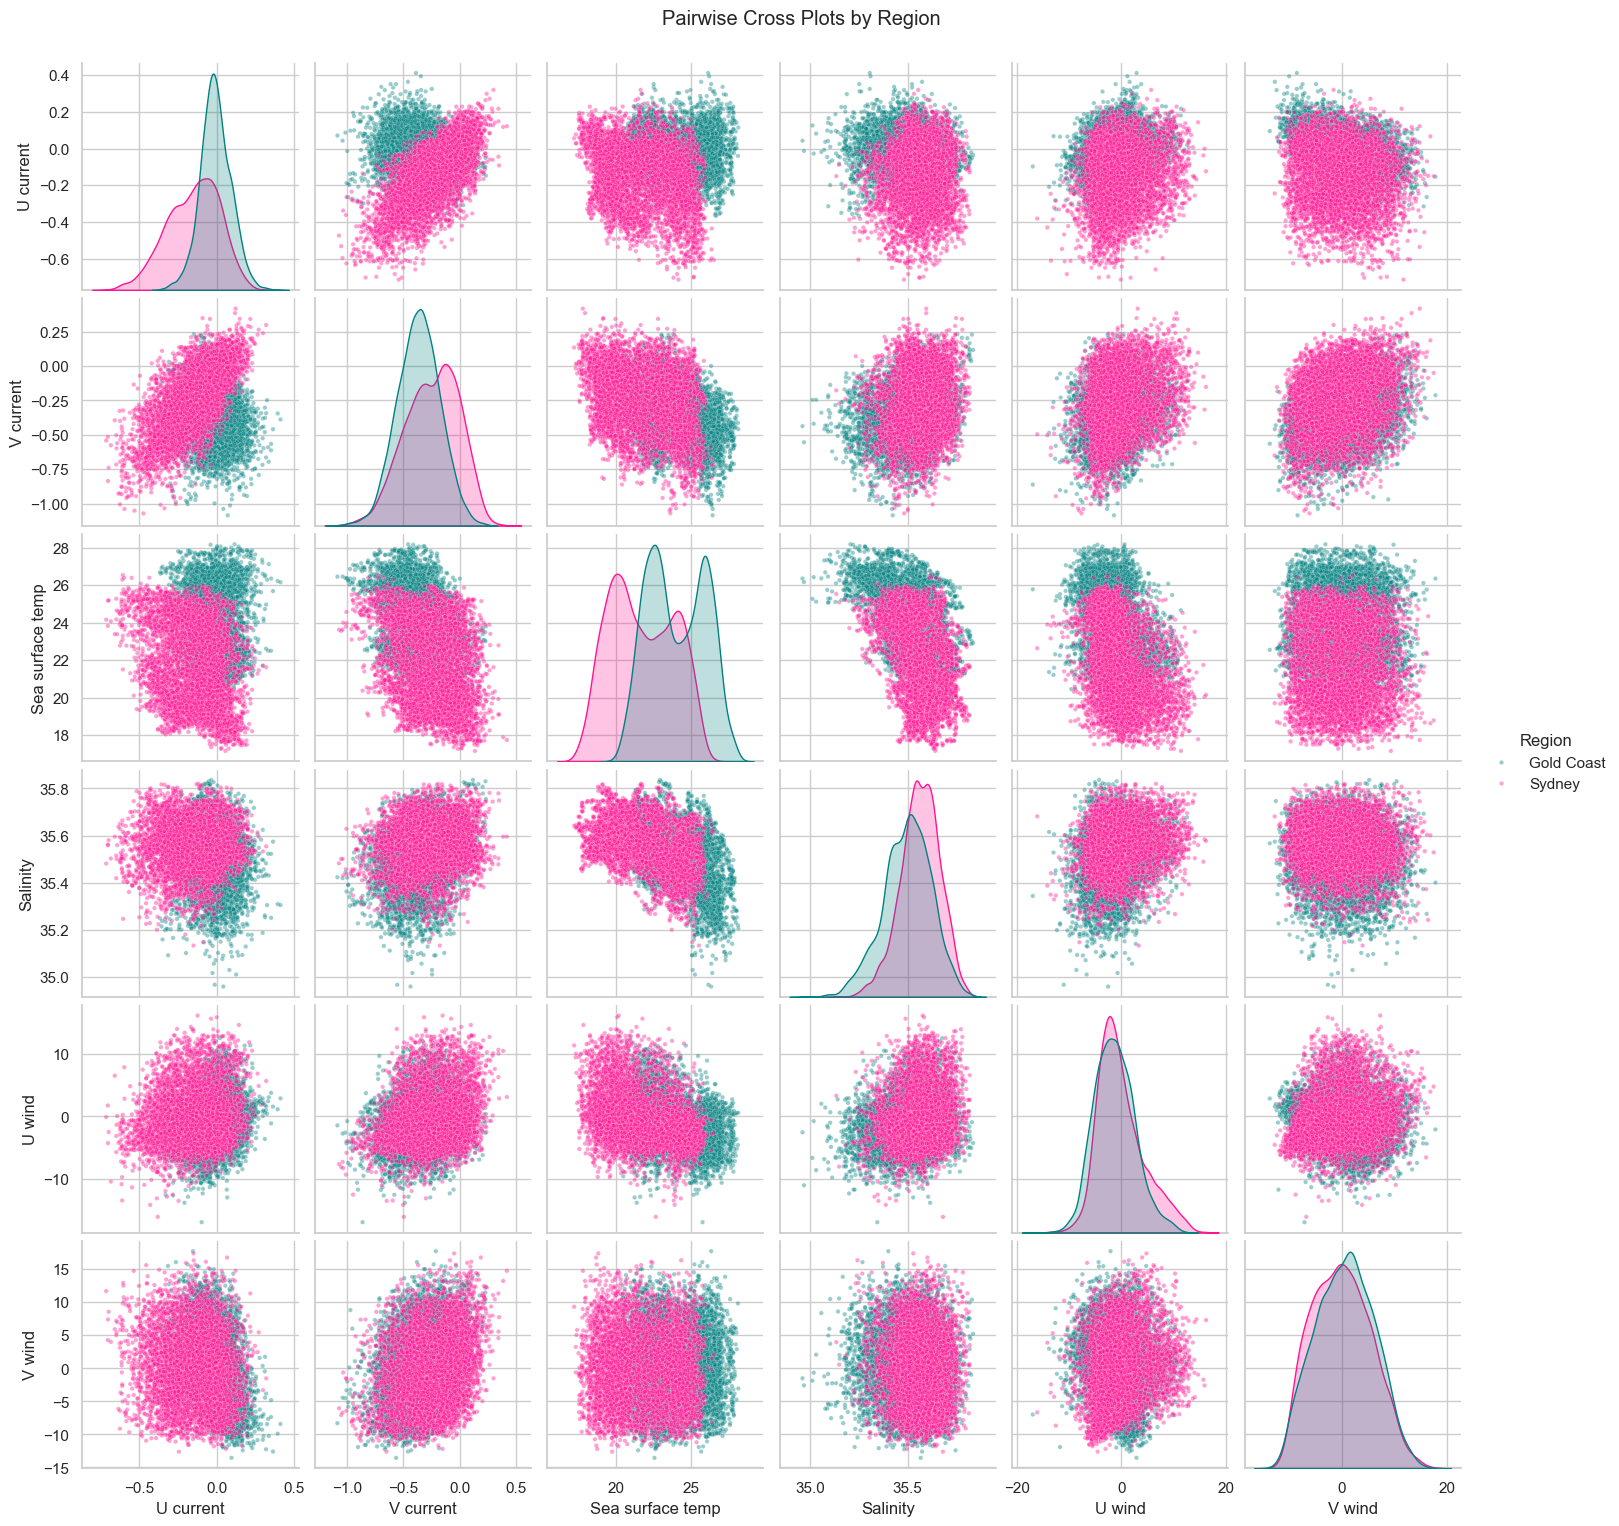

In [18]:
#cross plots by region
sns.set(style="whitegrid")
cp = sns.pairplot(
    all_df,
    vars=["U current", "V current", "Sea surface temp", "Salinity", "U wind", "V wind"],
    hue="Region",
    diag_kind="kde",
    palette=palette,
    plot_kws={"alpha":0.4, "s":10})
cp.fig.suptitle("Pairwise Cross Plots by Region", y=1.02)
plt.show()

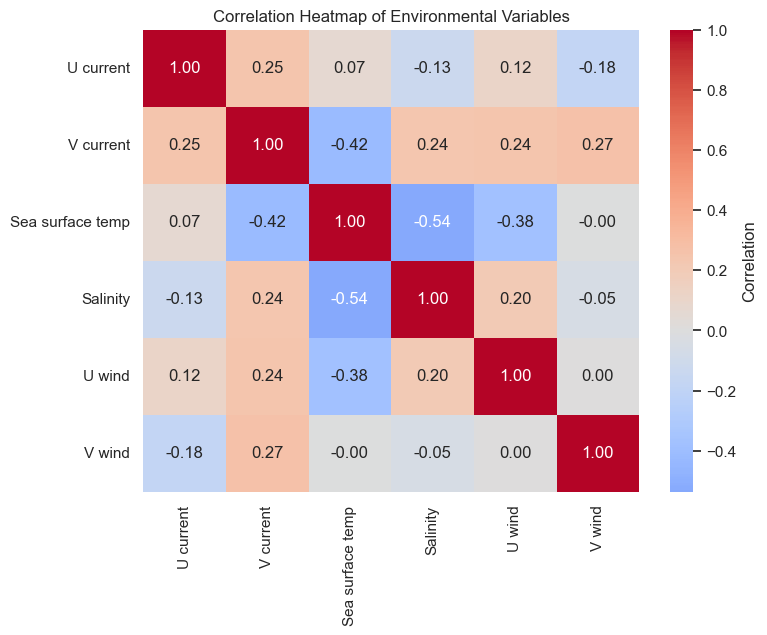

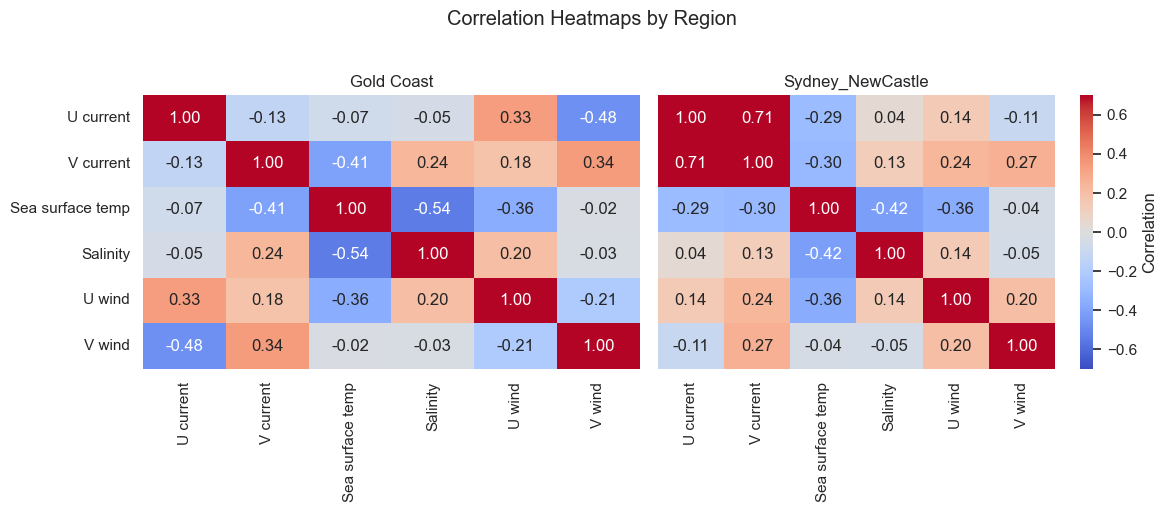

In [21]:
#correlation heatmap

corr = all_df.drop(columns=["Region"]).corr()
cmap = "coolwarm"   
plt.figure(figsize=(8,6))
sns.heatmap(
    corr, annot=True, fmt=".2f",
    cmap=cmap, center=0,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Heatmap of Environmental Variables")
plt.show()

#correlation heatmaps by region

e_vars = ["U current","V current","Sea surface temp","Salinity","U wind","V wind"]
corr_gc = gc_df[e_vars].corr()
corr_sy = sy_df[e_vars].corr()
cmap = "coolwarm" 

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

sns.heatmap(corr_gc, ax=axes[0], cmap=cmap, center=0, vmin=-0.7, vmax=0.7,
            annot=True, fmt=".2f", cbar=False)
axes[0].set_title("Gold Coast")

sns.heatmap(corr_sy, ax=axes[1], cmap=cmap, center=0, vmin=-0.7, vmax=0.7,
            annot=True, fmt=".2f", cbar_kws={'label':'Correlation'})
axes[1].set_title("Sydney_NewCastle")

plt.suptitle("Correlation Heatmaps by Region", y=1.02)
plt.tight_layout()
plt.show()



Summary for Sydney
count    1821.000000
mean       53.672158
std       221.514938
min         0.000000
25%         0.000000
50%         0.000000
75%        23.000000
max      4450.000000
Name: stings_sum, dtype: float64
Binary counts:
 stings_binary
0    0.731466
1    0.268534
Name: proportion, dtype: float64

Summary for Gold Coast
count     797.000000
mean       32.899624
std       108.964184
min         0.000000
25%         0.000000
50%         0.000000
75%        24.000000
max      1704.000000
Name: stings_sum, dtype: float64
Binary counts:
 stings_binary
0    0.715182
1    0.284818
Name: proportion, dtype: float64


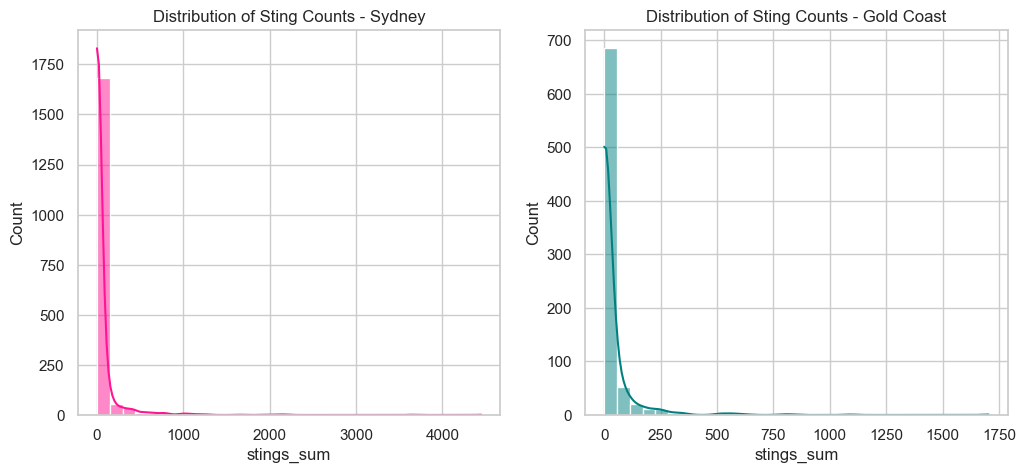

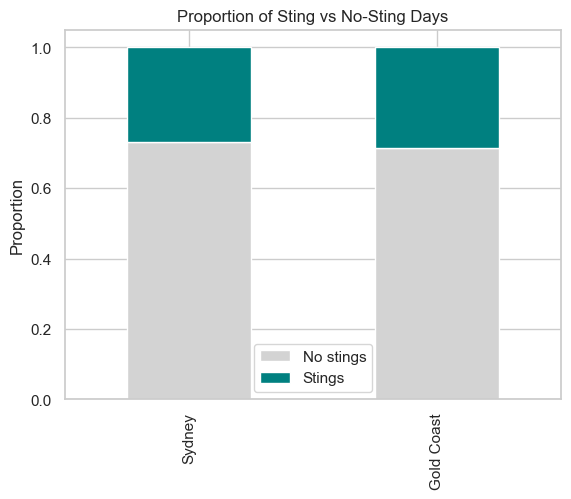

In [23]:
#exploring sting data 

def sting_summary(df, region):
    print(f"\nSummary for {region}")
    print(df["stings_sum"].describe())
    print("Binary counts:\n", df["stings_binary"].value_counts(normalize=True))

sting_summary(sy, "Sydney")
sting_summary(gc, "Gold Coast")

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(sy["stings_sum"], bins=30, kde=True, color=palette["Sydney"], ax=axes[0])
axes[0].set_title("Distribution of Sting Counts - Sydney")

sns.histplot(gc["stings_sum"], bins=30, kde=True, color=palette["Gold Coast"], ax=axes[1])
axes[1].set_title("Distribution of Sting Counts - Gold Coast")

plt.show()


binary_df = pd.DataFrame({
    "Sydney": sy["stings_binary"].value_counts(normalize=True),
    "Gold Coast": gc["stings_binary"].value_counts(normalize=True)
}).T

binary_df.plot(kind="bar", stacked=True, color=["lightgray","teal"])
plt.title("Proportion of Sting vs No-Sting Days")
plt.ylabel("Proportion")
plt.legend(["No stings","Stings"])
plt.show()

In [34]:
#matching sting data with environment data

def daily_env_from_np(arr, region, channels):
    means = np.nanmean(arr, axis=(2, 3))  
    out = pd.DataFrame(means, columns=channels)
    out['date'] = dates
    out['Region'] = region
    return out

gc_env = daily_env_from_np(gc_main, 'Gold Coast', channel_names)
sy_env = daily_env_from_np(sy_main, 'Sydney', channel_names)

env_daily = pd.concat([gc_env, sy_env], ignore_index=True)
merged = env_daily.merge(stings, on=['Region','date'], how='inner')

print('Sydney rows:', (merged.Region=='Sydney').sum(),
      'Gold Coast rows:', (merged.Region=='Gold Coast').sum(),
      'Total:', len(merged))


Sydney rows: 1658 Gold Coast rows: 744 Total: 2402


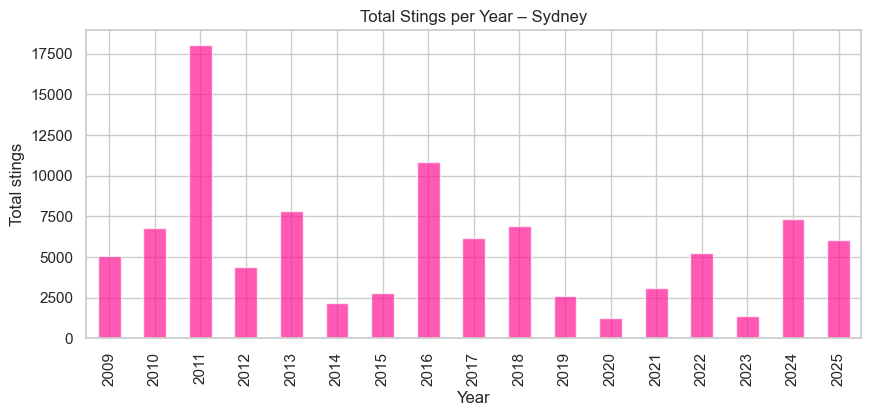

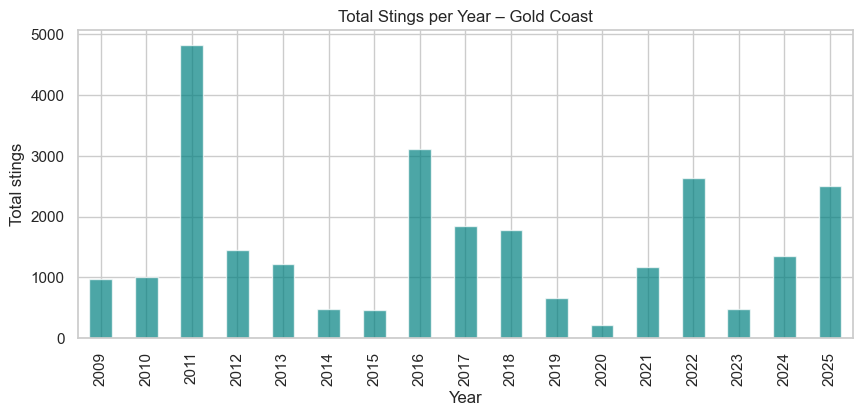

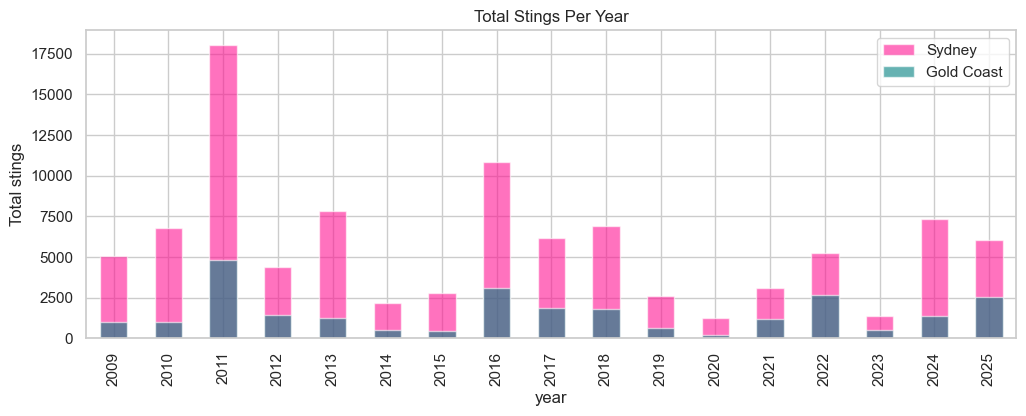

In [38]:
#yearly trends for stings

sy['year'] = sy['date'].dt.year
gc['year'] = gc['date'].dt.year

# Sydney yearly trend
plt.figure(figsize=(10,4))
sy.groupby('year')['stings_sum'].sum().plot(
    kind='bar', color='deeppink', alpha=0.7
)
plt.title('Total Stings per Year – Sydney')
plt.ylabel('Total stings')
plt.xlabel('Year')
plt.show()

# Gold Coast yearly trend
plt.figure(figsize=(10,4))
gc.groupby('year')['stings_sum'].sum().plot(
    kind='bar', color='teal', alpha=0.7
)
plt.title('Total Stings per Year – Gold Coast')
plt.ylabel('Total stings')
plt.xlabel('Year')
plt.show()

#combined
plt.figure(figsize=(12,4))
sy.groupby('year')['stings_sum'].sum().plot(kind='bar', alpha=0.6, color='deeppink', label='Sydney')
gc.groupby('year')['stings_sum'].sum().plot(kind='bar', alpha=0.6, color='teal', label='Gold Coast')
plt.title('Total Stings Per Year')
plt.ylabel('Total stings')
plt.legend()
plt.show()



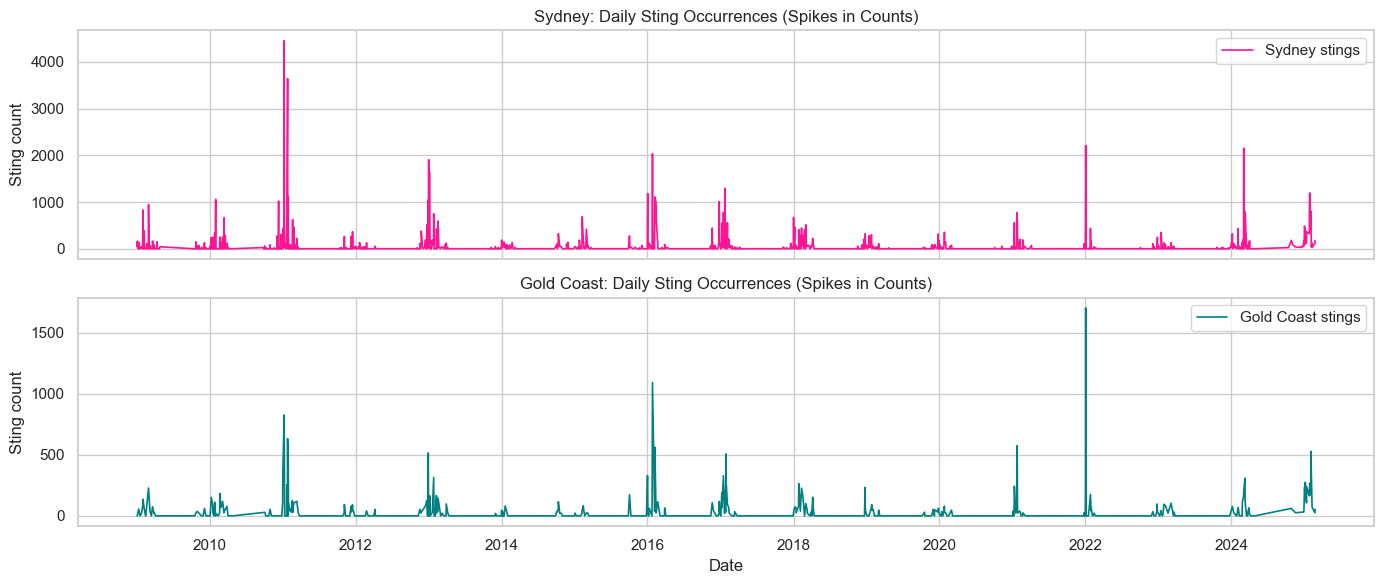

In [40]:
#time series plot of daily sting occurrences

sy_plot = sy.set_index('date').sort_index()
gc_plot = gc.set_index('date').sort_index()
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

# Sydney plot
axes[0].plot(sy_plot.index, sy_plot['stings_sum'].fillna(0),
             color='deeppink', linewidth=1.2, label='Sydney stings')
axes[0].set_title("Sydney: Daily Sting Occurrences (Spikes in Counts)")
axes[0].set_ylabel("Sting count")
axes[0].legend()

# Gold Coast
axes[1].plot(gc_plot.index, gc_plot['stings_sum'].fillna(0),
             color='teal', linewidth=1.2, label='Gold Coast stings')
axes[1].set_title("Gold Coast: Daily Sting Occurrences (Spikes in Counts)")
axes[1].set_ylabel("Sting count")
axes[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


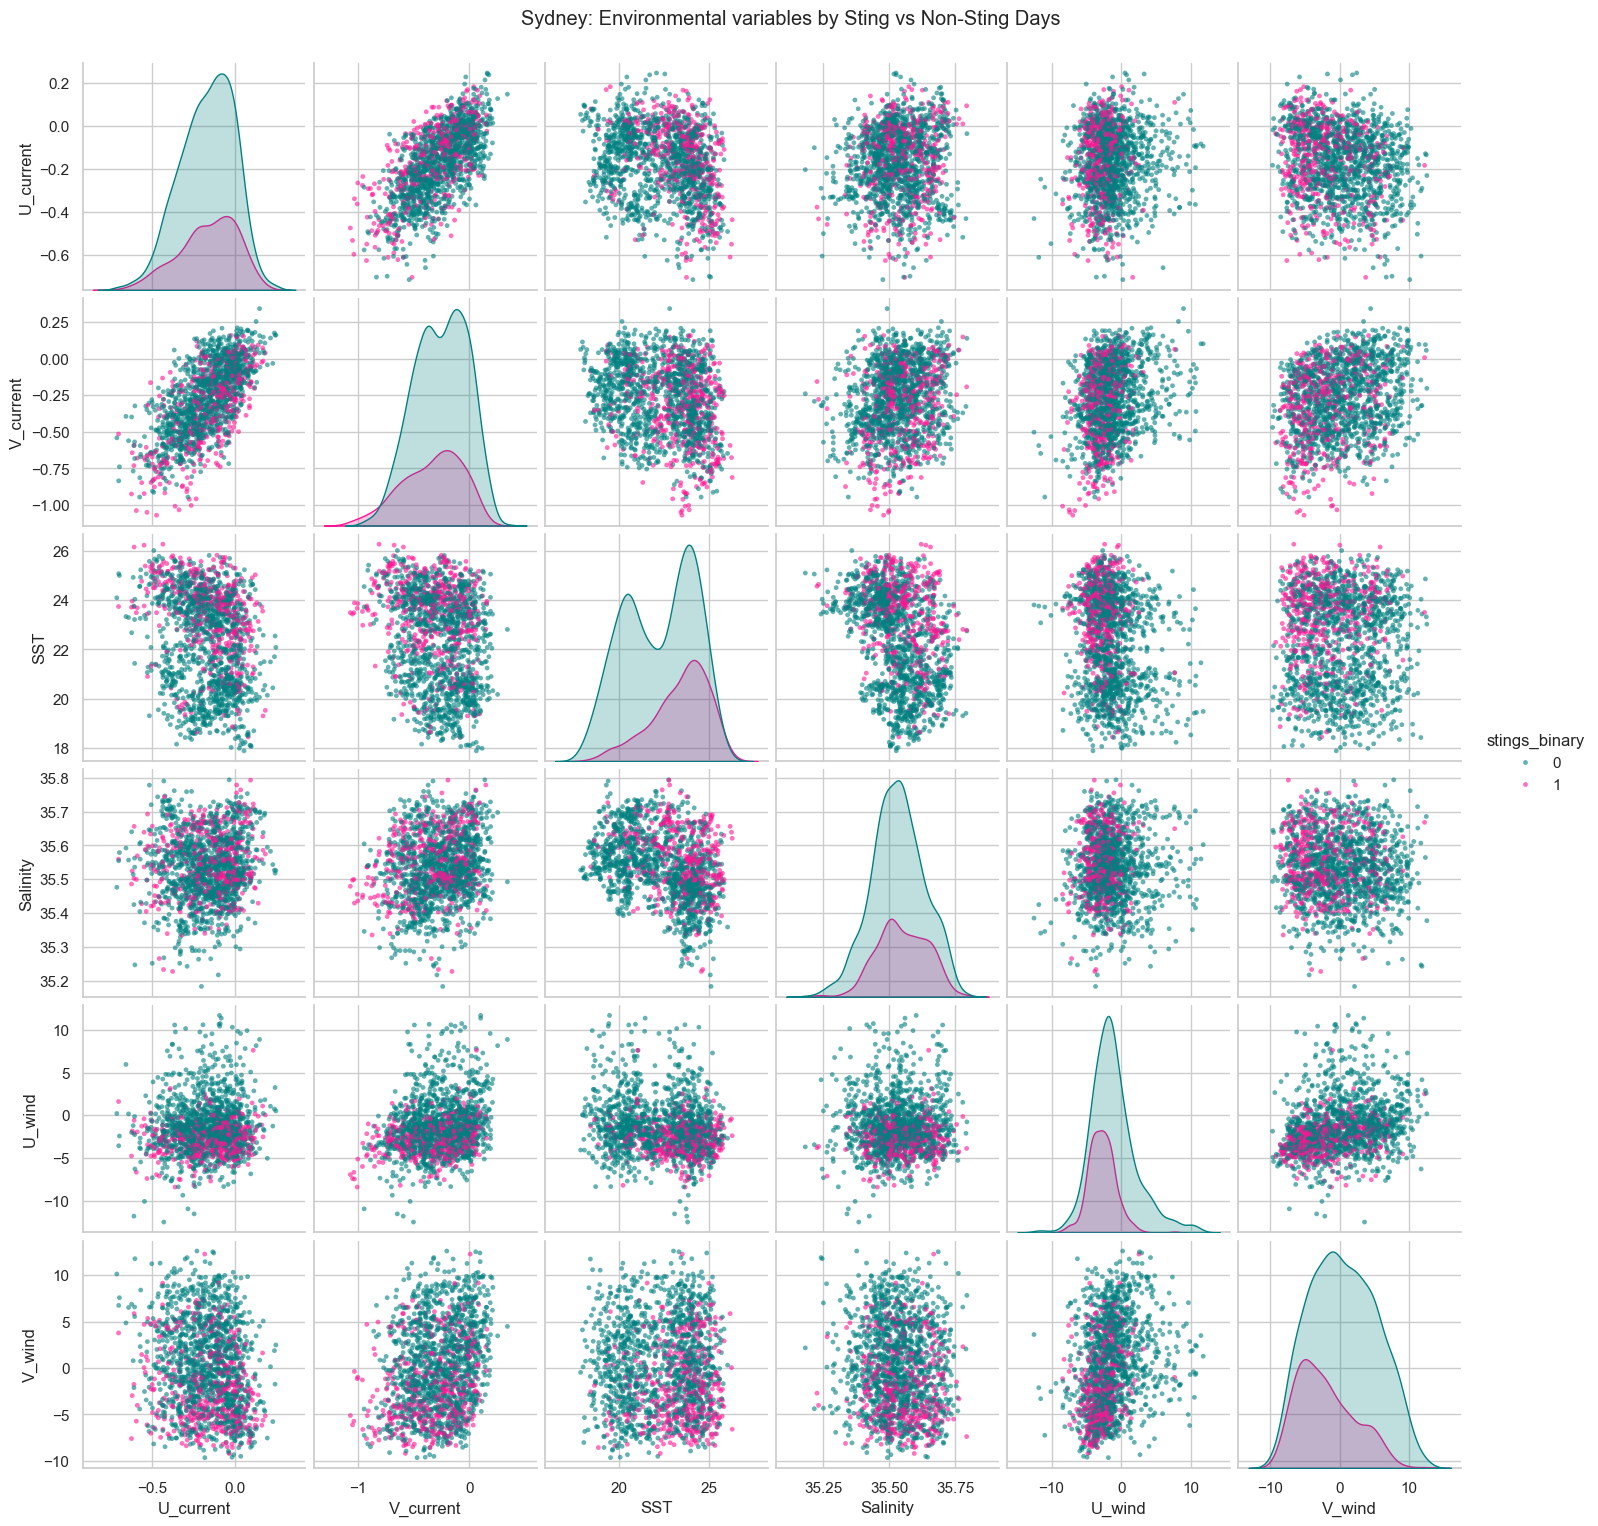

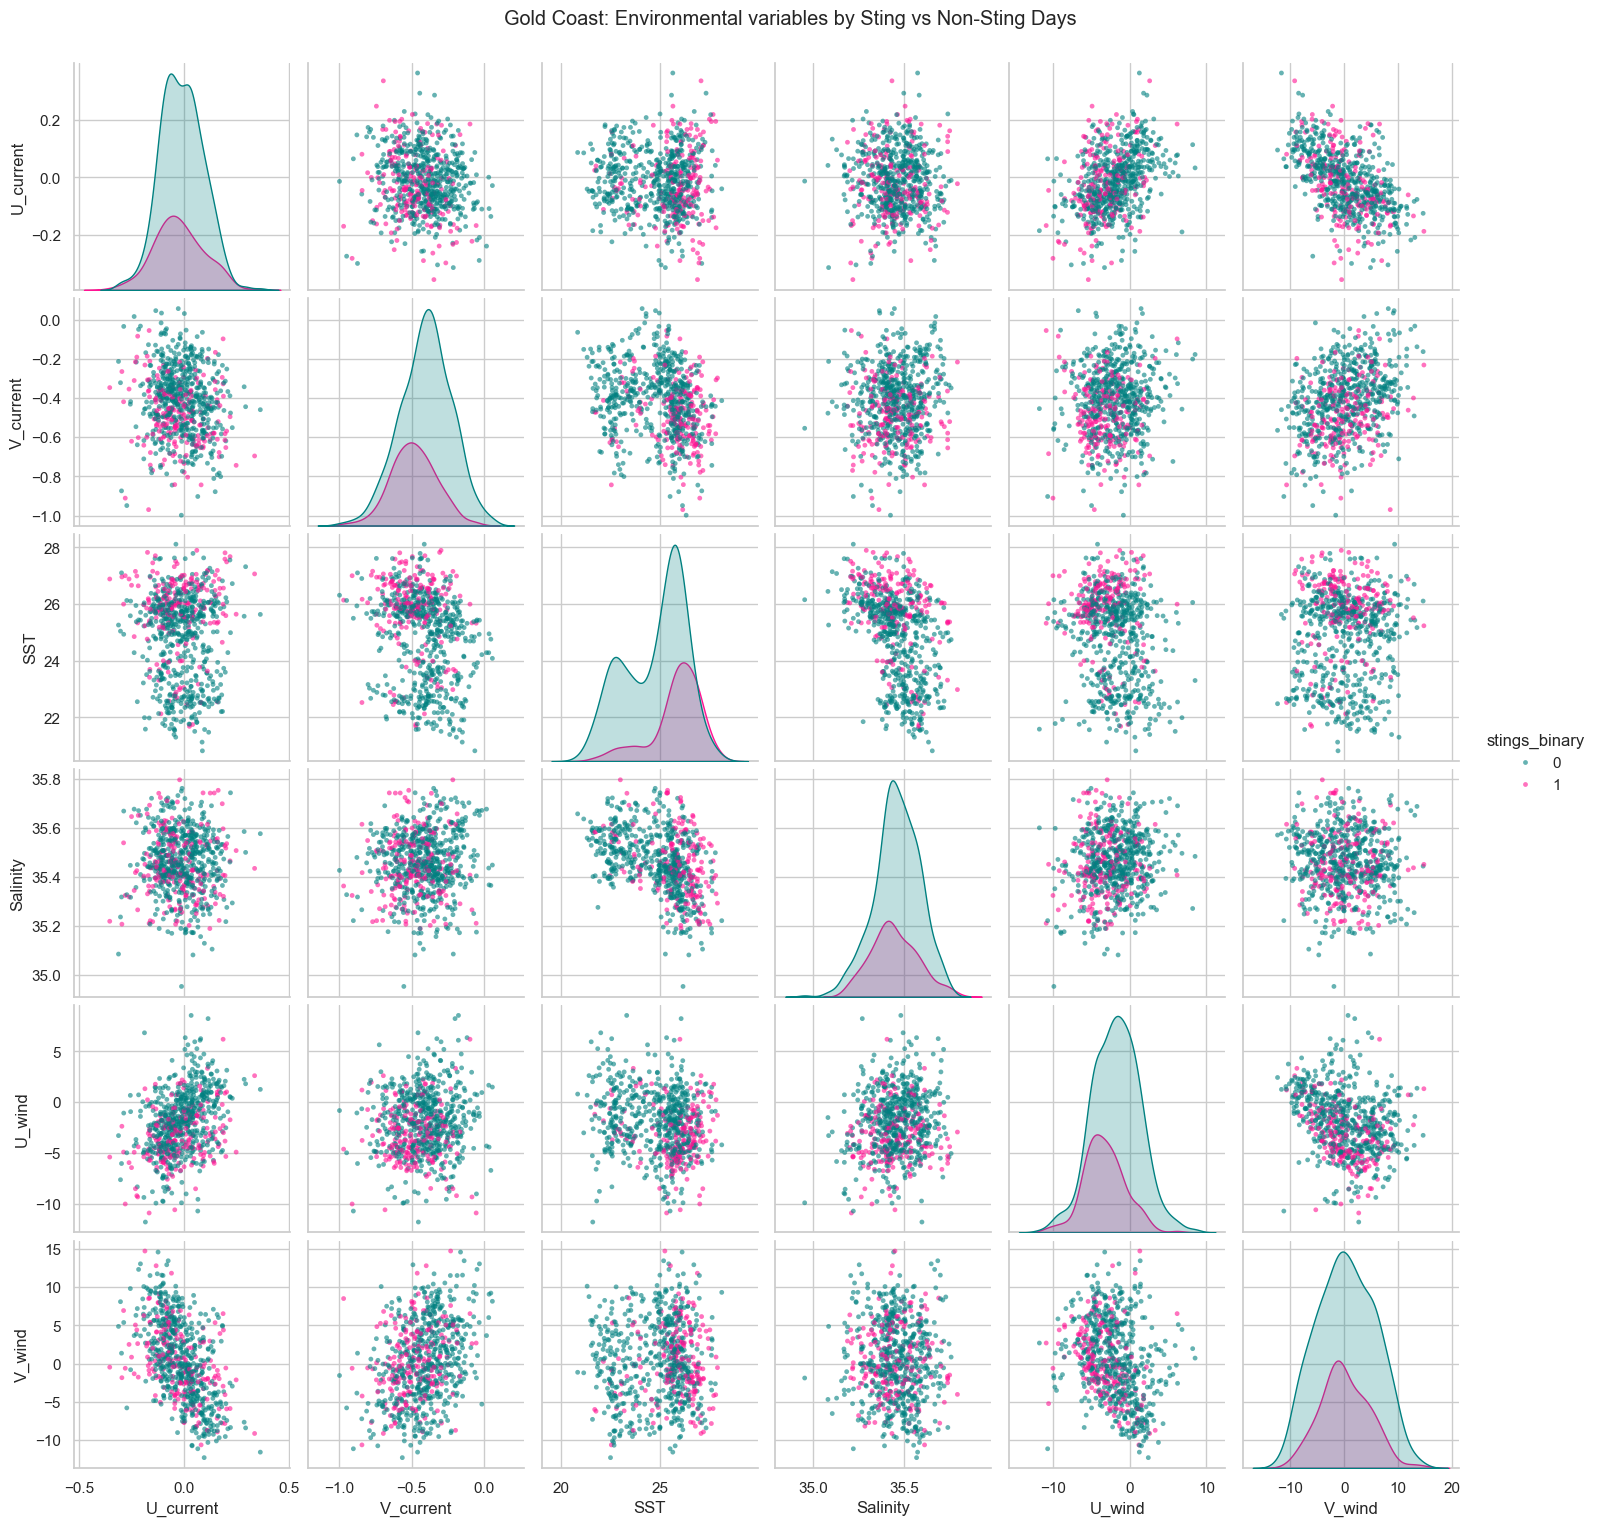

In [43]:
#cross plots of environmental varibles with sting days

rename_map = {
    "U current":"U_current",
    "V current":"V_current",
    "Sea surface temp":"SST",
    "Salinity":"Salinity",
    "U wind":"U_wind",
    "V wind":"V_wind"
}
df = merged.rename(columns=rename_map, errors="ignore")

#Sydney
sy_df = df[df["Region"]=="Sydney"].copy()
h = sns.pairplot(
    sy_df,
    vars=["U_current","V_current","SST","Salinity","U_wind","V_wind"],
    hue="stings_binary",
    diag_kind="kde",
    palette={0:"teal", 1:"deeppink"},  
    plot_kws=dict(s=12, alpha=0.6, linewidth=0)
)
h.fig.suptitle("Sydney: Environmental variables by Sting vs Non-Sting Days", y=1.02)
plt.show()

#Gold coast
gc_df = df[df["Region"]=="Gold Coast"].copy()
m = sns.pairplot(
    gc_df,
    vars=["U_current","V_current","SST","Salinity","U_wind","V_wind"],
    hue="stings_binary",
    diag_kind="kde",
    palette={0:"teal", 1:"deeppink"},   
    plot_kws=dict(s=12, alpha=0.6, linewidth=0)
)
m.fig.suptitle("Gold Coast: Environmental variables by Sting vs Non-Sting Days", y=1.02)
plt.show()